In [1]:
from os import listdir
from tqdm import tqdm
import xml.etree.ElementTree as ET
# import modules & set up logging
import numpy as np
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import remove_stopwords
# Load word2vec pre-train model
import gensim
import gensim.downloader as api
import gensim.models.keyedvectors as word2vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

## Get all the sentences (text) and the correspondent entailments (hypothesis) from the dataset

In [3]:
DS_PATH = "rteFormatData"
#DS_PATH = "/content/drive/MyDrive/Colab Notebooks/ENTAILMENT_GRAPH_ENG_V2.0/data/ENTAILMENT_GRAPH_RTE_FORMAT_ENG_V2.0/rteFormatData"

In [4]:
files = [f for f in listdir(DS_PATH)]
trees = []
entailment_pairs = []
sentences = []

for file in files:
    trees.append(ET.parse(DS_PATH+'/'+file))

for tree in trees:
    root = tree.getroot()
    for pair in root.findall('pair'):
        if pair.attrib['entailment'] == 'ENTAILMENT':
            text = pair.find('t').text.lower()
            hypothesis = pair.find('h').text.lower()
            sentences.append(text)
            sentences.append(hypothesis)
            entailment_pairs.append((text, hypothesis))

# Remove duplicates
entailment_pairs = list(set([i for i in entailment_pairs]))

## Get dataset to train the Casual Language Model

In [5]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

Reusing dataset wikitext (C:\Users\aless\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
100%|██████████| 3/3 [00:00<00:00, 69.32it/s]


In [6]:
#datasets['train'][300]['text']

## Load a pre-trained embedding model for evaluation

In [7]:
#PATH = api.load("word2vec-google-news-300", return_path=True)
PATH = "word2vec-google-news-300\word2vec-google-news-300.gz"
#PATH = "drive/MyDrive/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
gn_model = word2vec.KeyedVectors.load_word2vec_format(PATH, binary=True)
#weights = torch.FloatTensor(gn_model.wv.vectors)

# Training Sets

## Generate vocabulary

In [8]:
# train word2vec on the two sentences
def group_texts(examples):
    text = ''
    for entry in examples:
        text += ' ' + entry['text']  
    return text

V = Dictionary([['<PAD>']])

text = group_texts(datasets['train']).split()
V.add_documents([text])

for sentence in sentences:
    V.add_documents([sentence.split()])

In [9]:
def training_sequence(seq, dictionary):
    idxs = dictionary.doc2idx(seq)
    # remove unknown tokens
    if -1 in idxs: idxs.remove(-1)
    return torch.tensor(idxs, dtype=torch.long)

## Casual training set preprocessing

In [10]:
sentence_len = 5
n_tokens = len(text)

X_c = []
y_c = []

for idx in range(len(text) - sentence_len - 1):
    X_c.append(training_sequence(text[idx:idx+sentence_len], V))
    y_c.append(training_sequence(text[idx+1:idx+1+sentence_len], V))
    
X_c = torch.stack(X_c)
y_c = torch.stack(y_c)

## Tuning training set preprocessing

In [11]:
max_sentence_size = 0

for sentence in sentences:
    l = len(sentence.lower().split())
    if l > max_sentence_size:
        max_sentence_size = l

In [12]:
def build_tuning_ts(entailment_pairs):
    X = []
    y = []

    for text, hypothesis in entailment_pairs:
        text = text.lower().split()
        hypothesis = hypothesis.lower().split()
      
        if len(text) < max_sentence_size:
            text = text + ['<PAD>'] * (max_sentence_size-len(text))
        
        if len(hypothesis) < max_sentence_size:
            hypothesis = hypothesis + ['<PAD>'] * (max_sentence_size-len(hypothesis))
        
        X.append(training_sequence(text, V))
        y.append(training_sequence(hypothesis, V))

    X = torch.stack(X)
    y = torch.stack(y)
    return X, y

In [13]:
X_t, y_t = build_tuning_ts(entailment_pairs)

## LSTM model

In [137]:
class LSTMlm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMlm, self).__init__()
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # The linear layer that maps from hidden state space to target space
        self.hidden2tag = nn.Linear(hidden_dim, target_size)

    def forward(self, X, X_lengths=[], padding=False):

        batch_size, seq_len= X.size()

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embeddings(X)

        # ---------------------
        # 2. Run through RNN

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        if padding:X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)
        
        # run through LSTM
        X, _ = self.lstm(X)
        

        # undo the packing operation
        if padding:X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # ---------------------
        # 3. Project to tag space

        # first we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.hidden2tag(X)

        y_hat = F.log_softmax(X, dim=1)
        
        # reshape back to (batch_size, seq_len, target_size)
        y_hat = X.view(batch_size, seq_len, -1)

        return y_hat

## Model training

In [138]:
EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE = 100, 64, len(V), len(V)
model = LSTMlm(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE)
loss_function = nn.NLLLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=0.1)

https://github.com/afflint/inforet/blob/master/thematic-studies/language-models/L10-dialogue-generation.ipynb

## Model Evaluation

In [33]:
def evaluation_sequence(seq, dictionary):
    return [dictionary[token] for token in seq if token in dictionary.key_to_index]

In [18]:
def compute_cos_sim(sentence1, sentence2):
    sentence1 = remove_stopwords(sentence1)
    sentence2 = remove_stopwords(sentence2)
    sentence1 = torch.Tensor(np.array(evaluation_sequence(sentence1.split(), gn_model))).mean(dim=0)
    sentence2 = torch.Tensor(np.array(evaluation_sequence(sentence2.split(), gn_model))).mean(dim=0)
    output = F.cosine_similarity(sentence1, sentence2, dim=0)
    return output

In [141]:
def apply_model(pairs):
    text_target_answer = []
    for text, target in pairs:
        doc = text.lower().split()
        s = training_sequence(doc, V)

        hypothesis = []
        for tensor in model(s.view(1, -1)):
            token_idx = tensor.argmax().item()
            hypothesis.append(V[token_idx])

        answer = ""
        for token in hypothesis:
            word = token.split('_')[0]
            #if word != "<PAD>":
            answer += word + " "

        text_target_answer.append((text, target, answer))

    return text_target_answer

In [19]:
import math

def evaluate_model(entailment_pairs):
    cos_sim = []
    n_nan = 0
    text_target_answer = apply_model(entailment_pairs)
    for tri in text_target_answer:
        _, target, answer = tri
        output = compute_cos_sim(target,answer)
        if (math.isnan(output)):
            n_nan += 1
        else:
            cos_sim.append(output)
            
    mean_cos_sim = sum(cos_sim) / len(cos_sim)
    return mean_cos_sim, n_nan

## Casual Language Model Training

In [101]:
N_EPOCHS = 10
N_SAMPLES = 1000
casual_model_loss = []

for epoch in tqdm(range(0, N_EPOCHS)):
    model.zero_grad()
    sent = X_c[:N_SAMPLES]
    target = y_c[:N_SAMPLES]
    scores = model(sent)
    loss = loss_function(scores.view(scores.shape[0] * scores.shape[1], -1) , torch.flatten(target))
    loss.backward()
    optimizer.step()

    casual_model_loss.append(loss)

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


## Model tuning

In [109]:
N_EPOCHS = 5
SAMPLE_RATE = 1
N_SAMPLES = 100
cos_sim_mean = []
n_nan = []
tuning_model_loss = []

for idx in tqdm(range(N_EPOCHS)):
    model.zero_grad()
    scores = model(X_t[:N_SAMPLES])
    target = y_t[:N_SAMPLES]
    loss = loss_function(scores.view(scores.shape[0] * scores.shape[1], -1) , torch.flatten(target))
    tuning_model_loss.append(loss)
    loss.backward()
    optimizer.step()

"""    if idx % SAMPLE_RATE == 0:
        mean_, n_nan_ = evaluate_model(entailment_pairs) # <----- sostituire con batched
        cos_sim_mean.append(mean_)
        n_nan.append(n_nan_)"""

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


'    if idx % SAMPLE_RATE == 0:\n        mean_, n_nan_ = evaluate_model(entailment_pairs) # <----- sostituire con batched\n        cos_sim_mean.append(mean_)\n        n_nan.append(n_nan_)'

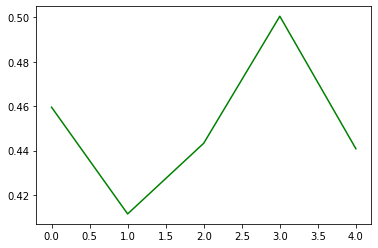

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0, int(N_EPOCHS/SAMPLE_RATE))
plt.plot(epochs, cos_sim_mean, 'g', label='Cosine similarity mean')
#plt.plot(epochs, n_nan, 'r', label='Missing answers')

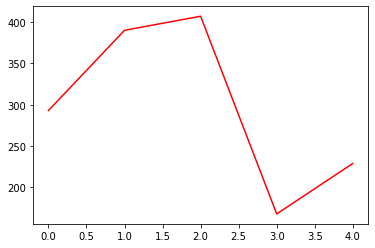

In [ ]:
plt.plot(epochs, n_nan, 'r', label='Missing answers')

In [142]:
text_target_answer = apply_model(entailment_pairs)

KeyError: 360457

In [130]:
for i in range(0,15): 
    print('text: ', text_target_answer[i][0], '\ntarget: ', text_target_answer[i][1], '\nanswer: ', text_target_answer[i][2], '\n')

NameError: name 'text_target_answer' is not defined